In [155]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import import_ipynb
from custom_matching_layers import *
from sklearn.model_selection import train_test_split

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
print(os.listdir("./datasets"))
print(os.listdir("./datasets/QQP"))

['MSRP', 'SICK', 'QQP']
['quora_duplicate_questions.tsv']


In [5]:
df_qqp = pd.read_csv('./datasets/QQP/quora_duplicate_questions.tsv', delimiter='\t')

In [6]:
df_qqp

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [7]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def text_to_word_list(text, remove_stop_words=False):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    
    if remove_stop_words:
        text = [wd for wd in text if wd not in stops]

    return text

[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
text_to_word_list('step by step')

['step', 'by', 'step']

In [9]:
df_qqp['question1'] = df_qqp['question1'].map(lambda x: text_to_word_list(x))
df_qqp['question2'] = df_qqp['question2'].map(lambda x: text_to_word_list(x))
df_qqp['len_q1'] = df_qqp['question1'].map(lambda x: len(x))
df_qqp['len_q2'] = df_qqp['question2'].map(lambda x: len(x))

In [10]:
df_qqp.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7


In [11]:
df_qqp.describe()

,id,qid1,qid2,is_duplicate,len_q1,len_q2
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198,11.161461,11.413189
std,116708.614503,157751.700002,159903.182629,0.482588,5.615627,6.519082
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000,7.000000,7.000000
50%,202144.500000,192182.000000,197052.000000,0.000000,10.000000,10.000000
75%,303216.750000,346573.500000,354692.500000,1.000000,13.000000,13.000000
max,404289.000000,537932.000000,537933.000000,1.000000,127.000000,244.000000


In [12]:
sentence_len = 30
max_sentence_length = sentence_len
embeddings_len = 300
max_unique_words = 20000

In [203]:
temp = df_qqp[(df_qqp['len_q1']<sentence_len) & (df_qqp['len_q2']<sentence_len)]
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7
...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...",0,14,13
404286,404286,18840,155606,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...",1,8,9
404287,404287,537928,537929,"[what, is, one, coin]","[what, is, this, coin]",0,4,4
404288,404288,537930,537931,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...",0,17,25


In [204]:
all_questions = list(temp['question1'].values) + list(temp['question2'].values)

In [205]:
# glove_embeddings = {}
# with open('8/model.txt') as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         glove_embeddings[word.lower()] = coefs

# print("Found %s word vectors." % len(glove_embeddings))

glove_embeddings = {}
with open('glove.6B/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word.lower()] = coefs

print("Found %s word vectors." % len(glove_embeddings))

Found 400000 word vectors.


In [206]:
len(glove_embeddings.keys())

400000

In [207]:
# temp = temp[:4000]

In [208]:
word_to_index = dict()
index_to_word = ['<unk>']
questions_cols = ['question1', 'question2']
q1_indexes = []
q2_indexes = []
hits = 0
misses = 0
for index, row in tqdm(temp.iterrows()):
    for question in questions_cols:
        q2n = []
        for word in row[question]:
            if word not in glove_embeddings:
                misses+=1
#                 print(word,"here1")
                continue
            hits+=1
            if word not in word_to_index:
#                 print(word,"here2")
                word_to_index[word] = len(index_to_word)
                q2n.append(len(index_to_word))
                index_to_word.append(word)
            else:
#                 print(word,"here3")
                q2n.append(word_to_index[word])
#         print(q2n)
#         print(row[question])
#         print(row)
#         break
        if question == 'question1':
            q1_indexes.append(q2n)
        else:
            q2_indexes.append(q2n)
#     if index>4:
#         break
print(hits,misses)
temp['q1_indexes'] = q1_indexes
temp['q2_indexes'] = q2_indexes

393262it [00:38, 10244.51it/s]
<ipython-input-208-2c0df14633ae>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['q1_indexes'] = q1_indexes


8449442 59245


<ipython-input-208-2c0df14633ae>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['q2_indexes'] = q2_indexes


In [209]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 11, 9, 12]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 11]"
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17,"[1, 2, 3, 13, 14, 15, 16, 17, 18, 17, 19, 20]","[1, 21, 22, 23, 3, 24, 25, 26, 3, 15, 16, 17, ..."
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10,"[28, 29, 18, 30, 3, 31, 14, 32, 33, 34, 35, 36...","[28, 29, 33, 31, 39, 40, 5, 41, 42, 43]"
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14,"[44, 45, 18, 46, 47, 48, 28, 29, 18, 49, 50]","[51, 3, 52, 53, 54, 55, 56, 57, 54, 2, 58, 5, ..."
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7,"[59, 60, 61, 9, 62, 63, 64, 65, 66, 67, 68, 69]","[59, 70, 21, 71, 9, 64, 62]"
...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...",0,14,13,"[28, 183, 3372, 114, 306, 9, 3, 21126, 504, 50...","[28, 183, 3372, 114, 306, 9, 10848, 504, 505, ..."
404286,404286,18840,155606,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...",1,8,9,"[99, 101, 2256, 306, 2, 579, 179, 1661]","[2, 50, 448, 80, 306, 2, 579, 179, 1661]"
404287,404287,537928,537929,"[what, is, one, coin]","[what, is, this, coin]",0,4,4,"[1, 2, 60, 9966]","[1, 2, 86, 9966]"
404288,404288,537930,537931,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...",0,17,25,"[1, 2, 3, 19121, 11310, 516, 14, 2565, 35, 289...","[18, 45, 1691, 2665, 2420, 1158, 18, 172, 7, 1..."


In [210]:
len(word_to_index)

59339

In [211]:
num_tokens = len(word_to_index) + 2
embedding_matrix = np.zeros((num_tokens, embeddings_len))
for word, i in word_to_index.items():
    embedding_matrix[i] = glove_embeddings[word]

In [212]:
temp = temp[temp['q1_indexes'].map(lambda x:len(x))<max_sentence_length]
temp = temp[temp['q2_indexes'].map(lambda x:len(x))<max_sentence_length]
temp.loc[:,'l'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q1_indexes'], maxlen=max_sentence_length)),index=temp.index)
temp.loc[:,'r'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q2_indexes'], maxlen=max_sentence_length)),index=temp.index)

In [213]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes,l,r
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 11, 9, 12]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 11]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17,"[1, 2, 3, 13, 14, 15, 16, 17, 18, 17, 19, 20]","[1, 21, 22, 23, 3, 24, 25, 26, 3, 15, 16, 17, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 21,..."
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10,"[28, 29, 18, 30, 3, 31, 14, 32, 33, 34, 35, 36...","[28, 29, 33, 31, 39, 40, 5, 41, 42, 43]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14,"[44, 45, 18, 46, 47, 48, 28, 29, 18, 49, 50]","[51, 3, 52, 53, 54, 55, 56, 57, 54, 2, 58, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7,"[59, 60, 61, 9, 62, 63, 64, 65, 66, 67, 68, 69]","[59, 70, 21, 71, 9, 64, 62]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...",0,14,13,"[28, 183, 3372, 114, 306, 9, 3, 21126, 504, 50...","[28, 183, 3372, 114, 306, 9, 10848, 504, 505, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404286,404286,18840,155606,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...",1,8,9,"[99, 101, 2256, 306, 2, 579, 179, 1661]","[2, 50, 448, 80, 306, 2, 579, 179, 1661]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404287,404287,537928,537929,"[what, is, one, coin]","[what, is, this, coin]",0,4,4,"[1, 2, 60, 9966]","[1, 2, 86, 9966]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404288,404288,537930,537931,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...",0,17,25,"[1, 2, 3, 19121, 11310, 516, 14, 2565, 35, 289...","[18, 45, 1691, 2665, 2420, 1158, 18, 172, 7, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, ...","[0, 0, 0, 0, 0, 0, 18, 45, 1691, 2665, 2420, 1..."


In [44]:
# temp = temp[:10000]

In [214]:
X_l = np.stack(temp['l'].to_numpy(),axis=1).T
X_r = np.stack(temp['r'].to_numpy(),axis=1).T
X = np.stack([X_l,X_r],axis=1)
# X = np.stack(temp['l'].to_numpy(),axis=1).T
Y = np.stack(temp['is_duplicate'].to_numpy())
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

## Building Model

In [226]:
embedding_layer = layers.Embedding(
    num_tokens,
    embeddings_len,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [227]:
left_input = layers.Input(shape=(max_sentence_length,), dtype='int32')
right_input = layers.Input(shape=(max_sentence_length,), dtype='int32')

In [228]:
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

In [229]:
# shared_bilstm = layers.Bidirectional(layers.LSTM(20, return_sequences=True))
forward_layer = layers.LSTM(10, return_sequences=True, go_backwards=True)
backward_layer = layers.LSTM(10, return_sequences=True, go_backwards=True)

In [230]:
forward_left = forward_layer(encoded_left)
forward_right = forward_layer(encoded_right)
backward_left = backward_layer(encoded_left)
backward_right = backward_layer(encoded_right)

In [231]:
perspectives = 10

In [232]:
# class matching_1_backward(layers.Layer):
#     def __init__(self, units=10):
#         super(matching_1_backward, self).__init__()
#         self.units = units
    
#     def build(self, input_shape):
#         self.w = self.add_weight(
#             shape=(input_shape[0][-1], self.units),
#             initializer="random_normal",
#             trainable=True,
#         )

#     def call(self, inputs, **kwargs):
#         left = tf.matmul(inputs[0],self.w)
#         right = tf.matmul(inputs[1][:,0],self.w)
#         m = layers.Dot(axes=(2, 1))([left,right])
#         return m
    
class matching_1_backward(layers.Layer):
    def __init__(self, units=7):
        super(matching_1_backward, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.matmul(inputs[0],self.w)
        right = tf.matmul(inputs[1][:,0],self.w)
        ms = []
        for i,p in enumerate(range(self.units)):
            custom_shape = list(left.shape)
            custom_shape[-1] = 1
            custom_shape[0] = -1
#             print(custom_shape)
            left_p=tf.reshape(left[:,:,i],custom_shape)
            custom_shape = list(right.shape)
            custom_shape[0] = -1
            custom_shape[-1] = 1
            right_p=tf.reshape(right[:,i],custom_shape)
            kk = layers.Dot(axes=(2, 1))([left_p,right_p])
            ms.append(kk)
        m = tf.stack(ms,axis=2)
        return m
    
    def compute_output_shape(self):
        return (self.w.shape[0])

In [233]:
class matching_1_forward(layers.Layer):
    def __init__(self, units=7):
        super(matching_1_forward, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.matmul(inputs[0],self.w)
        right = tf.matmul(inputs[1][:,-1],self.w)
        ms = []
        for i,p in enumerate(range(self.units)):
            custom_shape = list(left.shape)
            custom_shape[0] = -1
            custom_shape[-1] = 1
#             print(custom_shape)
            left_p=tf.reshape(left[:,:,i],custom_shape)
            custom_shape = list(right.shape)
            custom_shape[0] = -1
            custom_shape[-1] = 1
            right_p=tf.reshape(right[:,i],custom_shape)
            kk = layers.Dot(axes=(2, 1))([left_p,right_p])
            ms.append(kk)
        m = tf.stack(ms,axis=2)
        return m
    
    def compute_output_shape(self):
        return (self.w.shape[0])

In [234]:
match_1_forward_pq = matching_1_forward()([forward_left,forward_right])
match_1_forward_qp = matching_1_forward()([forward_right,forward_left])
match_1_backward_pq = matching_1_backward()([backward_left,backward_right])
match_1_backward_qp = matching_1_backward()([backward_right,backward_left])

In [235]:
all_matching_p = layers.Concatenate(axis=1)([match_1_forward_pq,match_1_forward_pq])
all_matching_q = layers.Concatenate(axis=1)([match_1_forward_qp,match_1_forward_qp])
aggregate = layers.Bidirectional(layers.LSTM(16))
aggregate_p = aggregate(all_matching_p)
aggregate_q = aggregate(all_matching_q)
concated = layers.Concatenate(axis=1)([aggregate_p,aggregate_q])
x = layers.Dense(32)(concated)
x = layers.Dense(1, activation='sigmoid')(x)

In [236]:
all_matching_p

<tf.Tensor 'concatenate_27/concat:0' shape=(None, 60, 7) dtype=float32>

In [237]:
model = keras.Model(inputs=[left_input,right_input], outputs=x, name="temp_model")
model.summary()

Model: "temp_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 300)      17802300    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 30, 10)       12440       embedding_4[0][0]       

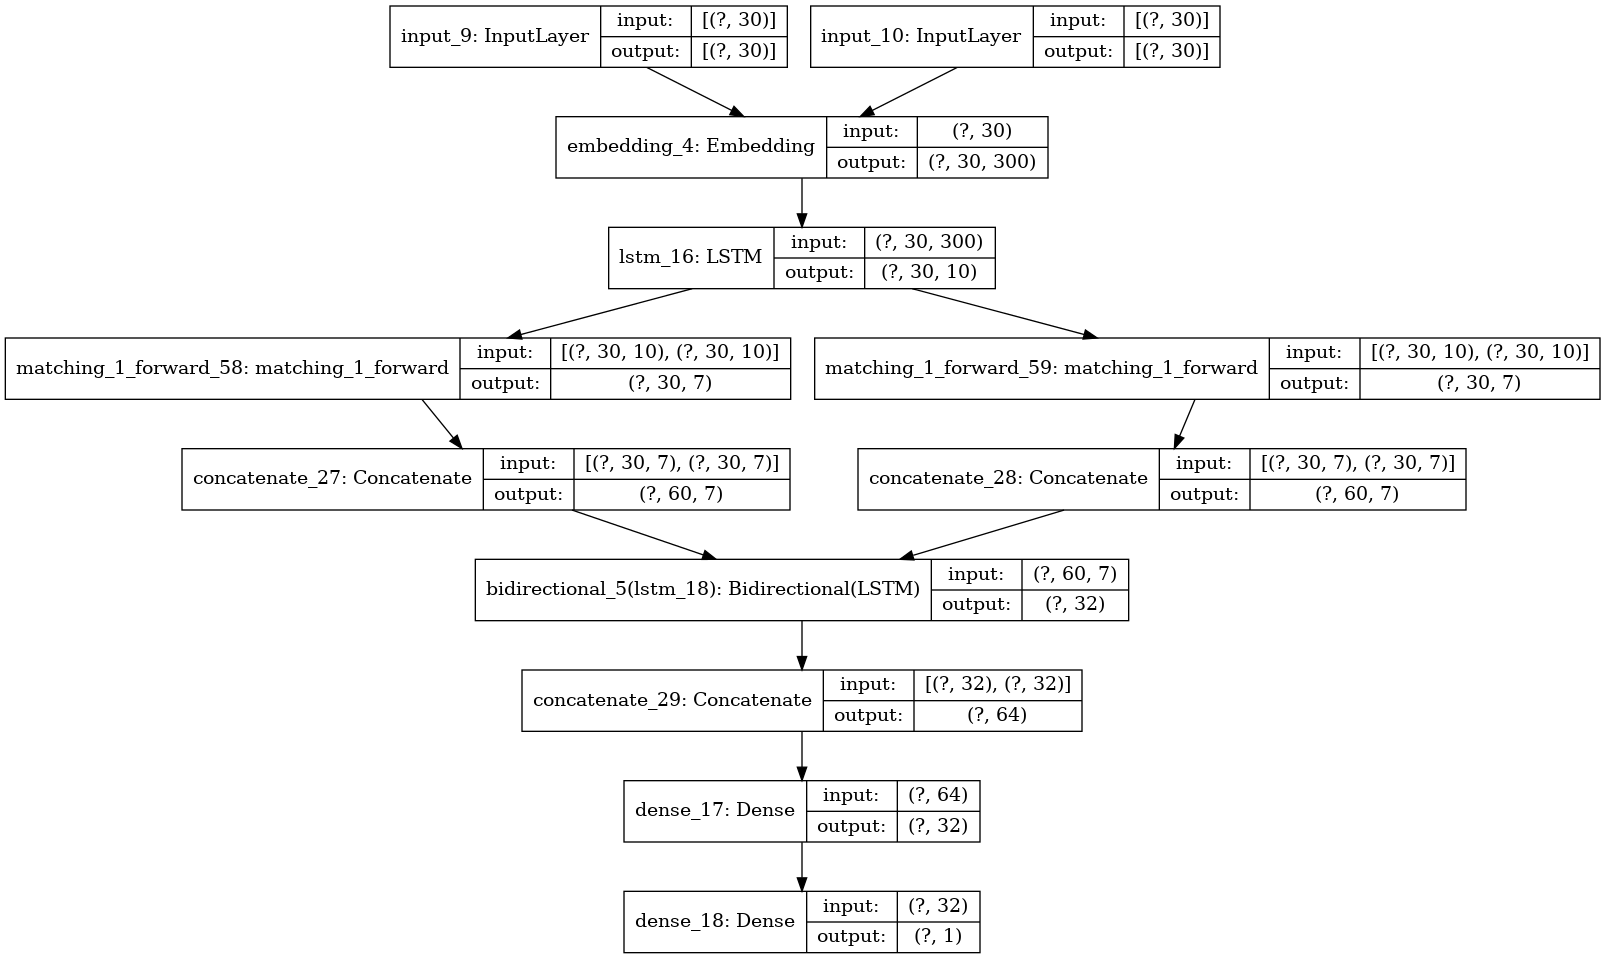

In [238]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [239]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [240]:
hist = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=10, epochs=10,
                            validation_data=([X_validation[:,0], X_validation[:,1]], Y_validation))

Epoch 1/10
31461/31461 [==============================] - 416s 13ms/step - loss: 0.5455 - accuracy: 0.7200 - val_loss: 0.5216 - val_accuracy: 0.7316
Epoch 2/10
31461/31461 [==============================] - 415s 13ms/step - loss: 0.5036 - accuracy: 0.7481 - val_loss: 0.4974 - val_accuracy: 0.7517
Epoch 3/10
31461/31461 [==============================] - 415s 13ms/step - loss: 0.4859 - accuracy: 0.7593 - val_loss: 0.4868 - val_accuracy: 0.7589
Epoch 4/10
31461/31461 [==============================] - 416s 13ms/step - loss: 0.4743 - accuracy: 0.7666 - val_loss: 0.4843 - val_accuracy: 0.7607
Epoch 5/10
31461/31461 [==============================] - 418s 13ms/step - loss: 0.4657 - accuracy: 0.7719 - val_loss: 0.4802 - val_accuracy: 0.7631
Epoch 6/10
31461/31461 [==============================] - 418s 13ms/step - loss: 0.4590 - accuracy: 0.7756 - val_loss: 0.4857 - val_accuracy: 0.7619
Epoch 7/10
31461/31461 [==============================] - 419s 13ms/step - loss: 0.4539 - accuracy: 0.7789

{'loss': [0.5454732179641724, 0.5035855770111084, 0.48585760593414307, 0.47432219982147217, 0.4657147228717804, 0.4589560329914093, 0.4539163112640381, 0.4490719139575958, 0.4450843036174774, 0.4419713616371155], 'accuracy': [0.7199762463569641, 0.7480968236923218, 0.7593203186988831, 0.7666341662406921, 0.7718501091003418, 0.7756103873252869, 0.7788938283920288, 0.7818752527236938, 0.7841320633888245, 0.7862362265586853], 'val_loss': [0.5216072201728821, 0.4974461495876312, 0.4867856502532959, 0.4842689633369446, 0.4801841676235199, 0.4857117533683777, 0.4724624454975128, 0.475385844707489, 0.4699373245239258, 0.4699738919734955], 'val_accuracy': [0.7316440343856812, 0.75171959400177, 0.7589284777641296, 0.7606956958770752, 0.763111412525177, 0.7618654370307922, 0.7659847736358643, 0.7644845247268677, 0.7706762552261353, 0.7702821493148804]}


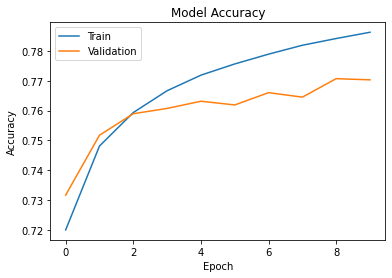

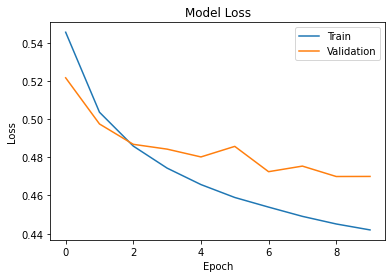

In [241]:
# Plot accuracy
print(hist.history)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [242]:
X_train[:,0].shape

(314609, 30)